# m6A Site Prediction Pipeline

This notebook implements a complete workflow to predict m6A RNA modification sites from nanopore direct RNA sequencing data. The dataset has already been cleaned and aggregated as 50_genes.csv.

---

## 1. Import Libraries

The necessary libraries are imported for processing, running logistic regression, and evaluation.


In [20]:
import sys
import subprocess

# List of required packages
packages = ["pandas", "numpy", "scikit-learn", "imbalanced-learn"]

for pkg in packages:
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score, confusion_matrix

## 2. Load Cleaned CSV

We load the preprocessed CSV file. This CSV already contains aggregated features for each transcript position.

In [22]:
df = pd.read_csv("../Lectures/6_TeamProject/Full_genes.csv")
print(df.shape, df['label'].value_counts())

(11027106, 14) label
0    10527532
1      499574
Name: count, dtype: int64


## 3. Handle Duplicate Transcript Positions

If multiple reads correspond to the same transcript position, we aggregate by taking the mean of the features. We also retain gene_id for grouping during train-test split.

In [23]:
feature_cols = [col for col in df.columns if col.startswith("feature_")]
agg_cols = feature_cols + ['label']
df = df.groupby(['transcript_id', 'transcript_position'], as_index=False).agg(
    {**{col: 'mean' for col in feature_cols}, 
     'label': 'mean',
     'gene_id': 'first'}  # keep gene_id
)
print(df.shape, df['label'].value_counts())

(121838, 13) label
0.0    116363
1.0      5475
Name: count, dtype: int64


## 4. Feature Engineering

Enhanced features are created to improve separability for m6A prediction. This includes averages, ratios, ranges, interactions, and polynomial terms.

In [24]:
def engineer_features(X):
    X_eng = X.copy()
    
    if X.shape[1] >= 9:
        # Positions: -1 (0-2), center (3-5), +1 (6-8)
        # Average features across positions
        avg_dwelling = np.mean(X[:, [0, 3, 6]], axis=1)
        avg_std = np.mean(X[:, [1, 4, 7]], axis=1)
        avg_mean = np.mean(X[:, [2, 5, 8]], axis=1)
        X_eng = np.column_stack([X_eng, avg_dwelling, avg_std, avg_mean])
        
        # Center-to-flanking ratios
        center_to_flanking_dwelling = X[:, 3] / (X[:, 0] + X[:, 6] + 1e-8) # 1e-8 to ensure no division by 0
        center_to_flanking_std = X[:, 4] / (X[:, 1] + X[:, 7] + 1e-8)
        center_to_flanking_mean = X[:, 5] / (X[:, 2] + X[:, 8] + 1e-8)
        X_eng = np.column_stack([X_eng, center_to_flanking_dwelling, 
                                 center_to_flanking_std, center_to_flanking_mean])
        
        # Signal ranges
        dwelling_range = np.max(X[:, [0, 3, 6]], axis=1) - np.min(X[:, [0, 3, 6]], axis=1)
        std_range = np.max(X[:, [1, 4, 7]], axis=1) - np.min(X[:, [1, 4, 7]], axis=1)
        mean_range = np.max(X[:, [2, 5, 8]], axis=1) - np.min(X[:, [2, 5, 8]], axis=1)
        X_eng = np.column_stack([X_eng, dwelling_range, std_range, mean_range])
        
        # Cross-feature interactions
        center_dwelling_x_mean = X[:, 3] * X[:, 5]
        center_std_x_mean = X[:, 4] * X[:, 5]
        X_eng = np.column_stack([X_eng, center_dwelling_x_mean, center_std_x_mean])
        
        # Polynomial features for center position
        center_dwelling_sq = X[:, 3] ** 2
        center_mean_sq = X[:, 5] ** 2
        center_std_sq = X[:, 4] ** 2
        X_eng = np.column_stack([X_eng, center_dwelling_sq, center_mean_sq, center_std_sq])
    
    return X_eng

X = engineer_features(df[feature_cols].values)
y = df['label'].values
groups = df['gene_id'].values

## 5. Train-Test Split by Gene ID

The dataset is split so that all positions from a single gene are either in train or test, avoiding leakage.

In [25]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (85771, 23) Test size: (36067, 23)


## 6. Handle Imbalanced Data (Undersampling)

Undersample the majority class to handle label imbalance.

In [26]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(sampling_strategy=0.33, random_state=42)
X_train_bal, y_train_bal = smote_enn.fit_resample(X_train, y_train)
print("Balanced train distribution:", pd.Series(y_train_bal).value_counts())

Balanced train distribution: 0.0    67555
1.0    19109
Name: count, dtype: int64


## 7. Scale Features

Robust scaling helps reduce the impact of outliers.

In [27]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

## 8. Train Logistic Regression Model

Train a logistic regression model with `class_weight='balanced'`.

In [28]:
model = LogisticRegression(
    penalty='l2',
    class_weight='balanced',  # still helps with imbalance
    solver='liblinear',       # robust for small/medium datasets
    random_state=42
)
model.fit(X_train_scaled, y_train_bal)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


## 9. Evaluate Model

Evaluate predictions using multiple metrics: classification report, ROC-AUC, PR-AUC, and confusion matrix.

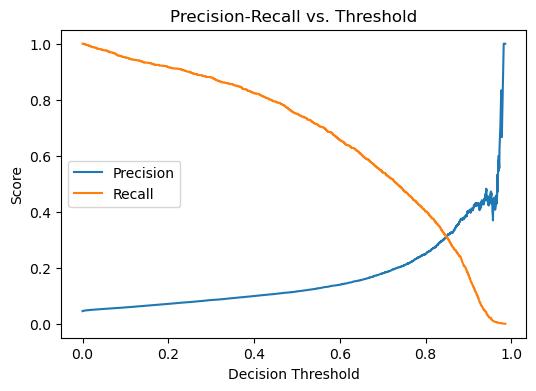

Best threshold (by F1): 0.833626858206048
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     34426
         1.0       0.29      0.35      0.32      1641

    accuracy                           0.93     36067
   macro avg       0.63      0.65      0.64     36067
weighted avg       0.94      0.93      0.93     36067

Accuracy: 0.9320154157540134
ROC-AUC: 0.8146017424510117
PR-AUC: 0.23157955675583725
Confusion Matrix:
 [[33046  1380]
 [ 1072   569]]


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve 

# Get predicted probabilities
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Plot
plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs. Threshold")
plt.show()

# Calculate threshold
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls + 1e-8))]
print("Best threshold (by F1):", best_threshold)

# Apply threshold
y_pred_custom = (y_prob >= best_threshold).astype(int)

# Re-evaluate
print(classification_report(y_test, y_pred_custom))
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))


## 10. Make Predictions and Save CSV

Generate probabilities for m6A sites and save in the required format: `transcript_id,transcript_position,score`.

In [30]:
# Subset the original dataframe for test rows
test_rows = df.iloc[test_idx].copy()  # ensures transcript_id and transcript_position match

# Create output DataFrame
predictions_df = pd.DataFrame({
    'transcript_id': test_rows['transcript_id'].values,
    'transcript_position': test_rows['transcript_position'].values,
    'score': y_prob
})

# Ensure score is between 0 and 1
predictions_df['score'] = predictions_df['score'].clip(0, 1)

# Save CSV
output_file = "predicted_m6a_sites.csv"
predictions_df.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")
predictions_df.head()

Predictions saved to predicted_m6a_sites.csv


,transcript_id,transcript_position,score
0,ENST00000002596,968,0.591230
1,ENST00000002596,1050,0.129405
2,ENST00000002596,1100,0.376744
3,ENST00000002596,1132,0.400985
4,ENST00000002596,1280,0.730921


## 11. Plot visualisations

Scatterplot of score against transcript position.

    transcript_position     score
11                   18  0.689104
19                   26  0.748674
31                   38  0.837303
46                   53  0.748514
58                   65  0.780320


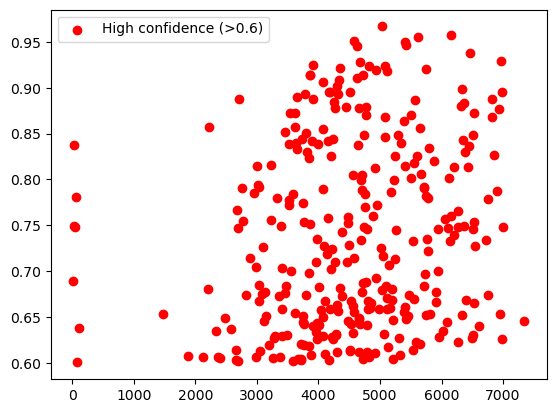

In [32]:
import pandas as pd

df = pd.read_csv("predicted_m6a_sites.csv")
df = df.groupby('transcript_position', as_index=False)['score'].mean()
high = df[df['score'] > 0.6]
print(high.head())

plt.scatter(high['transcript_position'], high['score'], color='red', label='High confidence (>0.6)')
plt.legend()